# Example: Dynamic Delta Neutral Hedging to Compensate for Price Fluctuations
[Delta hedging](https://en.wikipedia.org/wiki/Delta_neutral) is a strategy used in options trading to minimize the risk associated with price movements in the underlying asset. This approach involves using other options contracts or shares of the underlying asset to achieve a delta-neutral position, i.e., eliminating the position's directional bias.
* __Scenario__: You are long a `TSLA` put option (thus, you are short the shares) and are concerned about how the price movement of `TSLA` shares influences the overall risk of your position. Toward this risk, let's explore constructing a delta-neutral hedge.

From the buyer's perspective, by purchasing a put option, the buyer believes that `TSLA` shares will decline in price, i.e., the buyer is `bearish` on `TSLA.` Let's explore how delta-neutral hedging would work for a long put.

## Learning objectives
Fill me in.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites
Fill me in

### Constants

In [6]:
Δt = (1/390)*(1/252); # 1-min
number_of_trading_periods = 60; # How many trading periods will we simulate?
T = 60*(1/365); # Duration of trading periods in option years

Sₒ = 261.49; # TSLA share price
IVₒ = 0.627397; # IV for K = 210 put with 60-DTE
β = 2.32; # TSLA 5y monthly beta value 06-25-24
h = 366; # 6-points per trading day
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
number_of_samples = 1000; # number of samples to generate
sample_plot_index = 500; # which sample index to plot (must be <= number_of_samples)

Fill me in

In [8]:
option_dataset = load(joinpath(_PATH_TO_DATA, "TSLA-today-2023-06-19-exp-2023-08-18-dte-60d.jld2")) |> file -> file["data"];

In [9]:
example_put_data = option_dataset[50];

In [10]:
example_put_data["greeks"]

Dict{String, Any} with 4 entries:
  "theta" => -0.126845
  "gamma" => 0.00361099
  "vega"  => 0.242388
  "delta" => -0.154599

In [11]:
example_put_data["last_quote"]

Dict{String, Any} with 7 entries:
  "midpoint"     => 6.125
  "ask"          => 6.2
  "timeframe"    => "REAL-TIME"
  "bid_size"     => 118
  "ask_size"     => 69
  "bid"          => 6.05
  "last_updated" => 1686945599649808384

One-minute aggregate data for `TSLA` and `VIX` for 2023

In [13]:
underlying_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "TSLA-OHLC-1-min-aggregate-2023.csv"), DataFrame);
volatility_data_df = CSV.read(joinpath(_PATH_TO_DATA, "VIX-OHLC-1-min-aggregate-2023.csv"), DataFrame);

Compute the vwap, and the log_growth_matrix 

In [15]:
growth_rate_array = vwap(underlying_price_data_df) |> data -> log_growth_matrix(data, Δt = Δt);

Compute (u,d,p) parameters from data assuming a real-world probability measure

In [17]:
(ū,d̄,p̄) = (RealWorldBinomialProbabilityMeasure())(growth_rate_array; Δt = Δt);

## Task 1: Construct and Sample Future Market States
Fill me in.

### TODO: Sample Discrete Tree of Future Share Prices

In [20]:
price_tree_model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ = Sₒ, h = number_of_trading_periods));

Fill me in

In [22]:
samples_share_price = VLQuantitativeFinancePackage.sample(price_tree_model, number_of_trading_periods, 
    number_of_paths = number_of_samples);

`Unhide` the code block below to see how we plotted the `TSLA` volume weighted average price for your choice of the `sample_plot_index` variable:

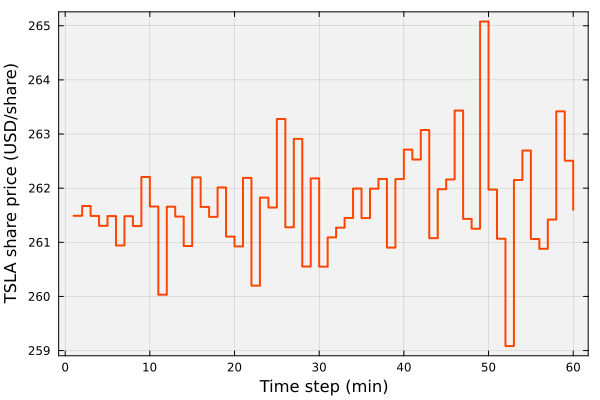

In [24]:
let
    plot(samples_share_price[:,sample_plot_index], linetype=:steppost, label="", lw=2, c=:orangered1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA share price (USD/share)", fontsize=18)
end

### TODO: Sample Future Implied Volatility
Fill me in

In [26]:
vol_of_vol = log_growth_matrix(volatility_data_df, Δt = 1.0, keycol=:close) |> x-> std(x); # keep on 1 min scale

In [27]:
samples_IV = Normal(IVₒ,vol_of_vol) |> d -> rand(d, number_of_trading_periods, number_of_samples)
samples_IV[1,1:end] .= IVₒ;

`Unhide` the code block below to view how we generated a plot of the implied volatility for a put option with a strike price of `K = 210 USD per share` on `TSLA` with `DTE = 60 days` until expiration, where the initial share price is `Sₒ = 261.49 USD per share`. This is for your chosen value of the `sample_plot_index` variable:

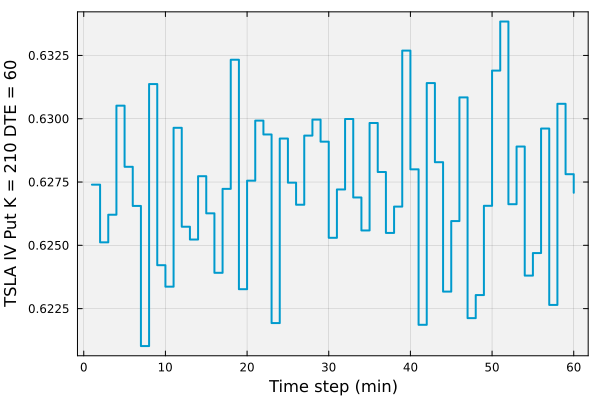

In [29]:
let
    plot(samples_IV[:,sample_plot_index], linetype=:steppost, label="", lw=2, c=:deepskyblue3, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA IV Put K = 210 DTE = 60", fontsize=18)
end

## Task 2: Construct a dynamic delta-neutral hedged position on TSLA
Fill me in

In [64]:
put_option_model = build(MyAmericanPutContractModel, (
    K = 210.0, 
    premium = example_put_data["last_quote"]["midpoint"], # mark price
    DTE = (60.5)*(1/365), # data from mid-day, add a little something something to the midpoint premium (ish) (all parameters fixed)
    sense = 1,
    copy = 1,
    IV = IVₒ
));

Compute Greeks

In [33]:
long_greek_dictionary = Dict{Union{MyAmericanPutContractModel,MyAmericanCallContractModel}, NamedTuple}();

In [34]:
long_greek_dictionary[put_option_model] = (
    delta_value = delta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    theta_value = theta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    vega_value = vega(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    gamma_value = gamma(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate));

In [35]:
(long_greek_dictionary[put_option_model].delta_value - example_put_data["greeks"]["delta"])/(example_put_data["greeks"]["delta"])

-0.03621843617238695

__Simulation loop__: Fill me in

In [83]:
tmpdata = Dict{Int64,Tuple}();
for i ∈ 1:number_of_trading_periods

    Sᵢ = samples_share_price[i,sample_plot_index];
    IVᵢ = samples_IV[i,sample_plot_index];

    # compute the premium -
    mᵢ = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = risk_free_rate, T = put_option_model.DTE, σ = IVᵢ)) |> (x-> populate(x, Sₒ = Sᵢ, h = h));
    Pᵢ = premium(put_option_model, mᵢ)    
    
    # compute Δᵢ for market state i -
    Δᵢ = delta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = IVᵢ, Sₒ = Sᵢ, μ = risk_free_rate)

    # compute the delta hedge (number of shares I need to be long)
    nᵢ = -100*Δᵢ;

    tmpdata[i-1] = (Δᵢ,nᵢ,Sᵢ,IVᵢ,Pᵢ)
end

In [78]:
tmpdata[0]

(-0.14900000000000002, 14.900000000000002, 261.49, 0.627397, 6.132)

## Task 3: Profit and loss for a dynamic delta-neutral hedged position in TSLA
Fill me in

In [87]:
tmp = DataFrame();

# initial -


for i ∈ 0:number_of_trading_periods-1

    data_tuple = tmpdata[i];
    Δᵢ = data_tuple[1];
    nᵢ = data_tuple[2];
    Sᵢ = data_tuple[3];
    IVᵢ = data_tuple[4];
    Pᵢ = data_tuple[5];
    
    row_df = (
        long_share_flow = -nᵢ*Sᵢ,
        option_flow = -100*Pᵢ
    )
    push!(tmp, row_df)
end
tmp

Row,long_share_flow,option_flow
,Float64,Float64
1,-3896.2,-613.2
2,-3872.72,-604.8
3,-3896.16,-610.3
4,-3893.45,-623.7
5,-3896.13,-615.0
6,-3888.02,-619.3
7,-3896.09,-597.5
8,-3893.37,-625.9
9,-3906.86,-594.6


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.